# Short introduction to tensorflow

[Tensorflow](https://www.tensorflow.org/) is the machine learning library of google that mostly concentrates on neural networks. It may be run across  multiple devices and supports graphics card acceleration. There are a ton of more features, and you could use it (and it is used) in a professional setting. Let me demonstrate it with a very basic example.

In [2]:
import tensorflow as tf
import matplotlib.pylab as plt
print("Tensorflow version: "+tf.version.VERSION)

Tensorflow version: 2.7.0


We load the fashion-MNIST dataset, a dataset of the same form and format as MNIST, only instead of handwritten digits it shows different types of clothing. The aim consists in identifying the type of clothing (shoe, T-shirt etc). See https://github.com/zalandoresearch/fashion-mnist

In [3]:
fashion = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # normalise so that all values in [0,1]

In [4]:
len(y_train), len(y_test)

(60000, 10000)

Let's have a look at a random datapoint:

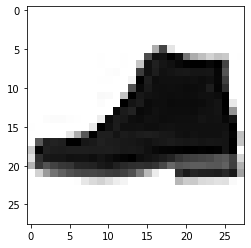

In [5]:
plt.imshow(x_train[42],cmap='binary')

It's a shoe!

We now define our neural network. It will be very simply: it will have an input, a hidden layer with ReLU activation and an output layer with no (that is with the identity) activation. tf.keras is a sublibrary of tensorflow that is designed to be easy to use. We pick a "sequential" model of a neural network: that simply means we'll have one layer after another. The input layer is a "flatten" layer that transforms the 28x28 pictures into a vector (of length $28\cdot 28$). The hidden layer is a "dense" layer, that is, a fully connected layers. We specify it to have 128 neurons. Finally, the output layer is also dense, ie, fully connected.

Tensorflow offers a high-level library, keras, that is easy to use. 

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

When training a neural network we do not directly minimise the zero-one loss. Zero-one loss is not continuous and generally not easy to handle during learning. Instead, as in logistic regression, we're working with a surrogate loss function. Here, we pick cross entropy. We'll discuss this some other time. 

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Before we fit, we need to connect the model with the loss function, which we do by calling 'compile'. While we're at it, we also specify that, during training, we'd like to get some information on the training error. Or rather, instead of how the fraction of misclassified samples in the training, we request what fraction is correctly classified ('accuracy').

In [8]:
model.compile(loss=loss_fn, metrics=['accuracy'])

It's time to train the neural network. We specify the number of 'epochs' of training. An epoch is one complete turn through the training data. After a while, a number of epochs, we'll see that the training error (or rather the accuracy) does not decrease anymore. It makes no sense to train beyond that point, and in fact, it may be good to stop long before that. Training for too many epochs may reduce the training error, but at the same time test error may increase again at some point. 

In [9]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5067 - accuracy: 0.8213
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3787 - accuracy: 0.8646
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3469 - accuracy: 0.8762
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3306 - accuracy: 0.8836
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3190 - accuracy: 0.8893
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3103 - accuracy: 0.8922
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3027 - accuracy: 0.8945
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2934 - accuracy: 0.8983
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2884 - accuracy: 0.9035
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.284

What are these *epochs*? Those are complete runs through the training set. We'll see soon what is happening here.

We evaluate now on the test set, ie, compute the test error.

In [10]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.5323 - accuracy: 0.8706 - 376ms/epoch - 1ms/step


[0.5323281288146973, 0.8705999851226807]

Finally, let's look how to do a prediction.

In [11]:
model.predict(x_train[42:43])

array([[-59.101112, -74.61166 , -81.46284 , -73.97761 , -77.4332  ,
        -33.135063, -69.43782 , -16.92911 , -56.135624, -10.423384]],
      dtype=float32)

As we did not specify an activation function for the output layer, this is just the raw result of the hidden layer output mulitplied with the weights of the output layer. To turn this into a meaningful prediction we could either output which output neuron shows the maximum value or, a better option, pass the output into the softmax function. We'll talk about softmax later. The short explanation: softmax turns the output into probabilities, or better, confidence levels. 

In [12]:
which_one=1001
predictions=tf.nn.softmax(model.predict(x_train[which_one:which_one+1]))
predictions.numpy()

array([[2.9905816e-03, 2.7405419e-13, 9.9699175e-01, 7.1546420e-14,
        5.1007980e-08, 1.5001189e-24, 1.7583689e-05, 2.7974861e-31,
        4.5116405e-16, 7.3818559e-21]], dtype=float32)

Let's write this in a nicer way:

In [13]:
class_names=["T-shirt/top","Trousers","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
for c,p in zip(class_names,predictions.numpy()[0]):
    print("{:11}:{:6.2f}%".format(c,p*100))

T-shirt/top:  0.30%
Trousers   :  0.00%
Pullover   : 99.70%
Dress      :  0.00%
Coat       :  0.00%
Sandal     :  0.00%
Shirt      :  0.00%
Sneaker    :  0.00%
Bag        :  0.00%
Ankle boot :  0.00%


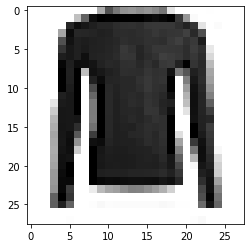

In [14]:
plt.imshow(x_train[which_one],cmap='binary')